## Week 12 Homework (10)

### Q1: define 

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

### Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.


### Q1: define 

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

#### • Gaussian Processes (GPs) and Stochastic Processes Generally

A **stochastic process** is a collection of random variables indexed by time, space, or any other domain. Formally, it is written as:

$$
\{ X_t \}_{t \in T}
$$

where each $X_t$ is a random variable, and $T$ is the index set. Stochastic processes describe uncertainty over functions or sequences.

A **Gaussian Process (GP)** is a specific type of stochastic process where **any finite subset of variables follows a multivariate normal distribution**. A GP is fully defined by its mean function $m(x)$ and covariance (kernel) function $k(x, x')$:

$$
f(x) \sim \mathcal{GP}(m(x), k(x, x'))
$$

- $m(x) = \mathbb{E}[f(x)]$ is the mean function.
- $k(x, x') = \text{Cov}(f(x), f(x'))$ is the kernel function.

GPs are often used in nonparametric Bayesian models to place distributions over functions directly.

**Relation to the Notebook**:  
Although Gaussian Processes are not used directly in the notebook, they share similarities with the Bayesian Mixture Models presented:
- Both are Bayesian models with latent variables (e.g., $\mathbf{v}_{ik}$ in mixtures; function values $f(x)$ in GPs).
- Both require inference over unobserved quantities.
- Both can be approached via variational inference or MCMC.

---

#### • Variational Inference Using the Evidence Lower Bound (ELBO)

**Variational Inference (VI)** is a technique used to approximate intractable posterior distributions by selecting a simpler distribution $q(\theta)$ from a chosen family and optimizing its parameters to be close to the true posterior $p(\theta | \text{data})$.

This is done by **minimizing the Kullback-Leibler (KL) divergence** between $q(\theta)$ and the true posterior:

$$
\text{KL}(q(\theta) \| p(\theta|\text{data}))
$$

However, since $p(\theta|\text{data})$ is often intractable, we instead maximize a **lower bound** on the log marginal likelihood, called the **Evidence Lower Bound (ELBO)**:

$$
\log p(\text{data}) \geq \mathbb{E}_{q(\theta)}[\log p(\text{data}|\theta)] - \text{KL}(q(\theta) \| p(\theta))
$$

The ELBO consists of:
- An **expected log-likelihood term**: encourages the variational distribution to explain the data well.
- A **KL divergence term**: encourages the variational distribution to stay close to the prior.



### Q2: Gaussian Processes in a New Context – Housing Prices by Location

In this demonstration, we use Gaussian Processes in PyMC to model housing prices based on spatial location (latitude and longitude). This showcases how GPs can capture smooth spatial patterns in real estate prices, which is a common application in spatial econometrics and geostatistics.


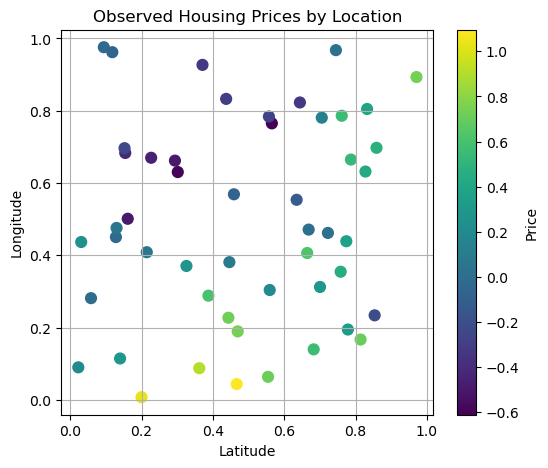

In [2]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Simulate some synthetic housing data
rng = np.random.default_rng(42)
n = 50

# Simulate latitude and longitude in a city grid (e.g., [0, 1] x [0, 1])
X = rng.uniform(0, 1, size=(n, 2))  # shape: (n_samples, 2)

# Simulate housing prices with spatial correlation
def true_function(xy):
    return (
        np.sin(4 * xy[:, 0]) * np.cos(4 * xy[:, 1])
        + 0.2 * xy[:, 0]
        + 0.3 * xy[:, 1]
    )

y_true = true_function(X)
y_obs = y_true + rng.normal(0, 0.2, size=n)  # add noise

# Plot the spatial distribution of housing prices
plt.figure(figsize=(6, 5))
sc = plt.scatter(X[:, 0], X[:, 1], c=y_obs, cmap="viridis", s=60)
plt.colorbar(sc, label="Price")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Observed Housing Prices by Location")
plt.grid(True)
plt.show()


### Build a GP Model in PyMC
We define a zero-mean GP with a Radial Basis Function (RBF) kernel to model the spatial correlation of prices.


In [4]:
with pm.Model() as gp_model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfNormal("η", sigma=1.0)
    σ = pm.HalfNormal("σ", sigma=0.5)

    # Covariance function (kernel)
    cov_func = η**2 * pm.gp.cov.ExpQuad(2, ℓ)

    # Define the GP prior
    gp = pm.gp.Marginal(cov_func=cov_func)

    # Likelihood
    y_ = gp.marginal_likelihood("y", X=X, y=y_obs, sigma=σ)

    trace = pm.sample(1000, chains=2, return_inferencedata=True, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [ℓ, η, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 40 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


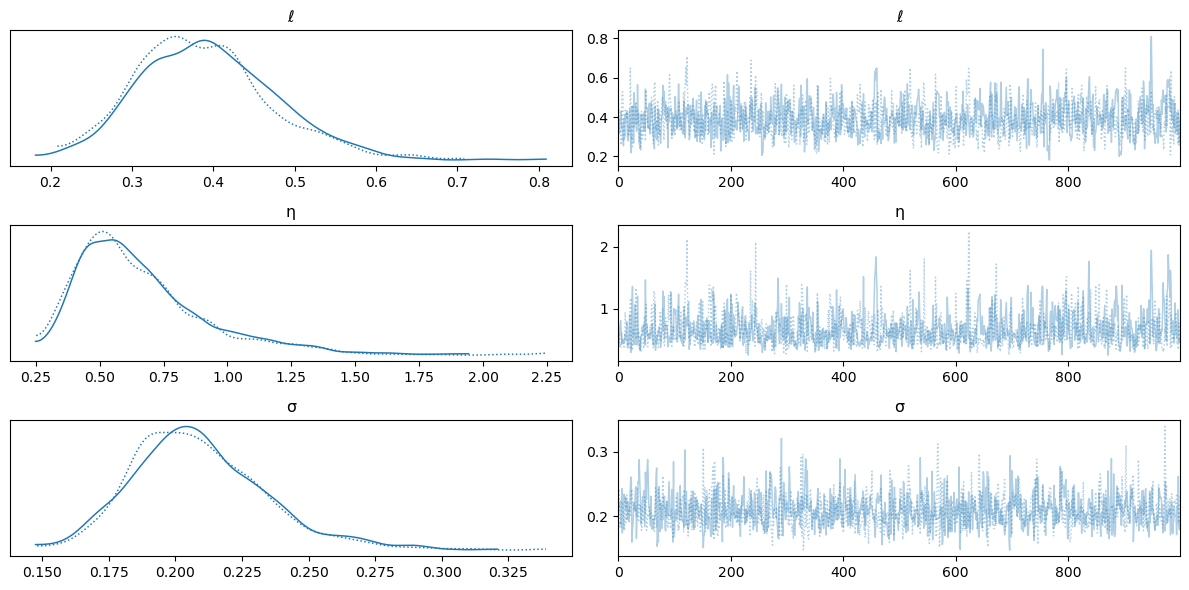

In [5]:
az.plot_trace(trace, var_names=["ℓ", "η", "σ"])
plt.tight_layout()
plt.show()


### Posterior Prediction over a Grid
We visualize the GP's predicted mean surface over a regular grid of locations.

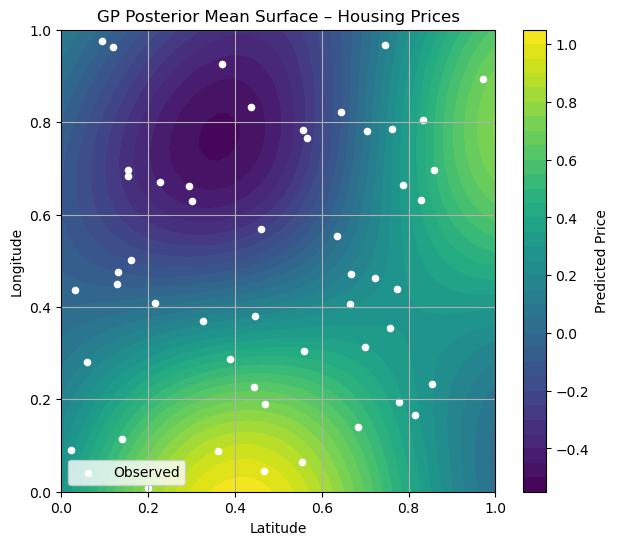

In [7]:
# Generate a grid of points to predict on
xx, yy = np.meshgrid(np.linspace(0, 1, 40), np.linspace(0, 1, 40))
X_new = np.column_stack([xx.ravel(), yy.ravel()])

# Fix: extract scalar values from the trace using .mean().item()
point = {
    "ℓ": trace.posterior["ℓ"].mean().item(),
    "η": trace.posterior["η"].mean().item(),
    "σ": trace.posterior["σ"].mean().item(),
}

with gp_model:
    mu_pred, var_pred = gp.predict(X_new, point=point, diag=True, pred_noise=True)

# Reshape for plotting
mu_pred = mu_pred.reshape(xx.shape)

plt.figure(figsize=(7, 6))
contour = plt.contourf(xx, yy, mu_pred, levels=30, cmap="viridis")
plt.colorbar(contour, label="Predicted Price")
plt.scatter(X[:, 0], X[:, 1], c="white", s=20, label="Observed")
plt.title("GP Posterior Mean Surface – Housing Prices")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend()
plt.grid(True)
plt.show()


**Summary**:

- This demonstration shows how Gaussian Processes can be used to model **spatial dependencies** in data, such as housing prices.
- The GP smoothly interpolates between observed points and captures uncertainty in regions with sparse data.
- The model structure is flexible and can be extended to include more covariates (e.g., size, age, number of rooms) in addition to location.

This is a powerful example of GPs applied outside the usual PyMC tutorials.


### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.


In [9]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
X, y = load_diabetes(return_X_y=True)
X = StandardScaler().fit_transform(X)
y = (y - y.mean()) / y.std()

# Subset for speed (optional)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.astype("float32")
y_train = y_train.astype("float32")


In [11]:
import pytensor.tensor as pt

n_hidden = 10
n_features = X_train.shape[1]

with pm.Model() as bnn_vi:
    w1 = pm.Normal("w1", mu=0, sigma=1, shape=(n_features, n_hidden))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(n_hidden,))
    
    w2 = pm.Normal("w2", mu=0, sigma=1, shape=(n_hidden,))
    b2 = pm.Normal("b2", mu=0, sigma=1)

    # ✅ Use pt.maximum for ReLU
    hidden = pt.maximum(0, pt.dot(X_train, w1) + b1)
    mu = pt.dot(hidden, w2) + b2

    sigma = pm.HalfNormal("sigma", 1.0)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

    approx = pm.fit(method="advi", n=20_000)


Finished [100%]: Average Loss = 526.61


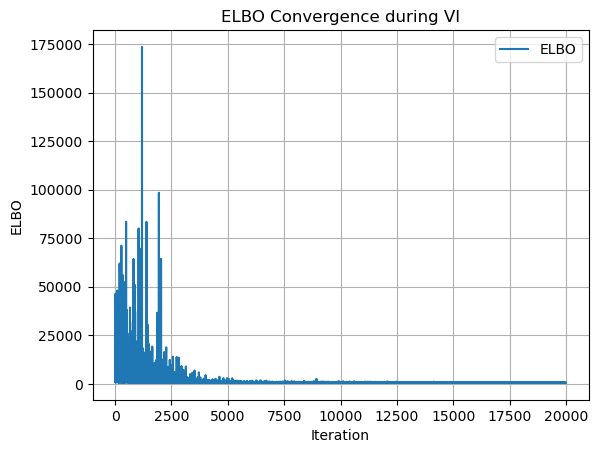

In [12]:
plt.plot(approx.hist, label="ELBO")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO Convergence during VI")
plt.grid(True)
plt.legend()
plt.show()

In [17]:
# No transpose necessary if we stack sample first
stacked = posterior_samples.stack(sample=("chain", "draw"))

w1_samples = stacked["w1"].values  # (sample, input_dim, hidden_dim)
b1_samples = stacked["b1"].values  # (sample, hidden_dim)
w2_samples = stacked["w2"].values  # (sample, hidden_dim)
b2_samples = stacked["b2"].values  # (sample,)


In [18]:
preds = []
for w1_i, b1_i, w2_i, b2_i in zip(w1_samples, b1_samples, w2_samples, b2_samples):
    hidden = np.maximum(0, X_test @ w1_i + b1_i)  # ReLU
    preds.append(hidden @ w2_i + b2_i)

preds = np.array(preds)
pred_mean = preds.mean(axis=0)
pred_std = preds.std(axis=0)



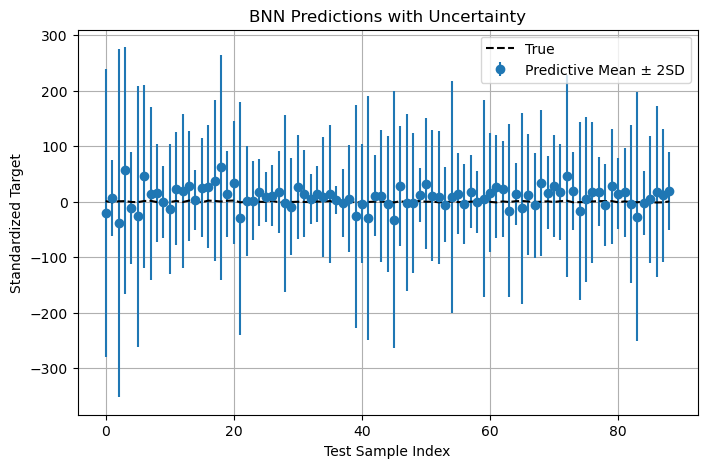

In [19]:
plt.figure(figsize=(8, 5))
plt.errorbar(range(len(y_test)), pred_mean, yerr=2*pred_std, fmt="o", label="Predictive Mean ± 2SD")
plt.plot(range(len(y_test)), y_test, "k--", label="True")
plt.xlabel("Test Sample Index")
plt.ylabel("Standardized Target")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()


**Summary**:

- This example demonstrates using **Variational Inference (ADVI)** to train a Bayesian Neural Network (BNN).
- The ELBO is maximized during fitting, and predictive uncertainty is captured through posterior predictive sampling.
- BNNs offer a principled way to model epistemic uncertainty and regularize overfitting in small datasets.
- This approach is scalable to larger datasets and deeper models by extending the architecture.

